In [1]:
import os
import sys
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt

%matplotlib inline

seed = 16
np.random.seed(seed)

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator


c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#check using system GPU for processing and declaring system/GPU parameters

from tensorflow.python.client import device_lib
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu
print(device_lib.list_local_devices())

# configure tensorflow before fitting model
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.99
sess = tf.Session(config=tf_config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 302559731472387033
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1493781708
locality {
  bus_id: 1
}
incarnation: 3279469307693349181
physical_device_desc: "device: 0, name: GeForce GTX 860M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [30]:
# changing directory for flow_from_directory method
os.chdir('C:\\Users\\Garrick\\Documents\\Springboard\\Capstone Project 2\\datasets')

In [31]:
# define functions to load data

def load_array(fname):
    return np.load(open(fname,'rb'))

In [32]:
# load in labels and data (as tensors)

train_labels=load_array('train_labels.npy')
valid_labels=load_array('valid_labels.npy')

In [33]:
train_tensor=load_array('train_dataset.npy')

In [34]:
def Normalize_Input(X):
    minimum=0
    maximum=255
    X-minimum/(maximum-minimum)
    return X  

In [35]:
train_tensor = Normalize_Input(train_tensor)

In [36]:
valid_tensor=load_array('valid_dataset.npy')

In [37]:
valid_tensor=Normalize_Input(valid_tensor)

In [48]:
num_classes = 120
batch_size = 48
input_shape = (224, 224, 3)


In [39]:

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, 
                             zoom_range=0.1, horizontal_flip=True)


train_generator = datagen.flow(x=train_tensor, y=train_labels, batch_size=batch_size)
validation_generator = datagen.flow(x=valid_tensor, y=valid_labels, batch_size=batch_size)


In [45]:
datagen.fit(train_tensor)

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
import keras.utils
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
K.set_image_dim_ordering('tf')

from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

from keras.callbacks import ModelCheckpoint


In [47]:
from keras.applications import VGG16
# Load the VGG model
# choosing VG166 architecture initially as my hand-built models with 3x3 filters perform the best and generally is more popular
# let us also add two fully-connected layers before the final output layer

vgg16_base = Sequential()
vgg16_base.add(VGG16(weights='imagenet',
                  include_top=False,
                pooling='avg'))

vgg16_base.add(Dense(1024, activation='relu'))
vgg16_base.add(BatchNormalization())
vgg16_base.add(Dropout(0.2))

vgg16_base.add(Dense(512, activation='relu'))

vgg16_base.add(Dropout(0.2))


vgg16_base.add(Dense(num_classes, activation='softmax'))
vgg16_base.layers[0].trainable = False

# compile
adam_op = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
vgg16_base.compile(loss='sparse_categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])
print(vgg16_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               61560     
Total para

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5', 
                               verbose=1, save_best_only=True)

vgg16_history = vgg16_base.fit_generator(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=800, 
                    epochs=25, 
                    callbacks=[early_stopping, checkpointer])

Epoch 1/25
800/800 [==============================] - 383s 478ms/step - loss: 3.5426 - acc: 0.1741 - val_loss: 2.5366 - val_acc: 0.3637

Epoch 00001: val_loss improved from inf to 2.53662, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5
Epoch 2/25
800/800 [==============================] - 383s 478ms/step - loss: 2.5087 - acc: 0.3540 - val_loss: 2.0910 - val_acc: 0.4542

Epoch 00002: val_loss improved from 2.53662 to 2.09101, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5
Epoch 3/25
800/800 [==============================] - 382s 477ms/step - loss: 2.1078 - acc: 0.4350 - val_loss: 1.8558 - val_acc: 0.5142

Epoch 00003: val_loss improved from 2.09101 to 1.85579, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5
Epoch 4/25
800/800 [==============================] - 382s 477ms/step - loss: 1.8441 - acc: 0.4897 - val_loss: 1.7256 - val_acc: 0.5287

Epoch 00004: val_loss improved from 1.85579 to 1.72564, saving mod

In [28]:
vgg16_base.save('vgg16_base.h5')

In [12]:
# lets plot/visualize the model training progress

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

font = {'family' : 'sans-serif',
        'weight' : 'medium',
        'size'   : 16}

plt.rc('font', **font)

In [13]:
def plot_history(history, figsize=(8,8)):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1, figsize=figsize)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    frame.set_color('white')
    
    ## Accuracy
    plt.figure(2, figsize=figsize)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    frame.set_color('white')
    plt.show()

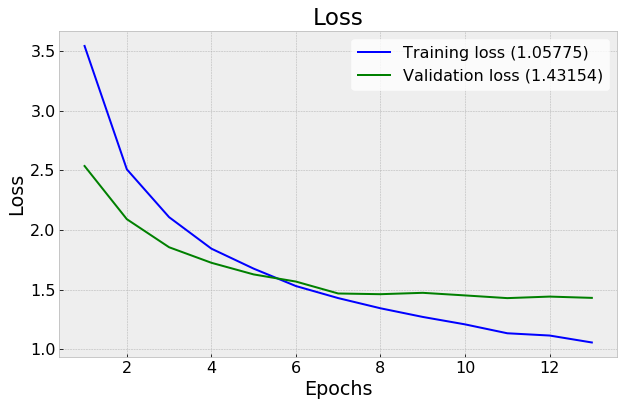

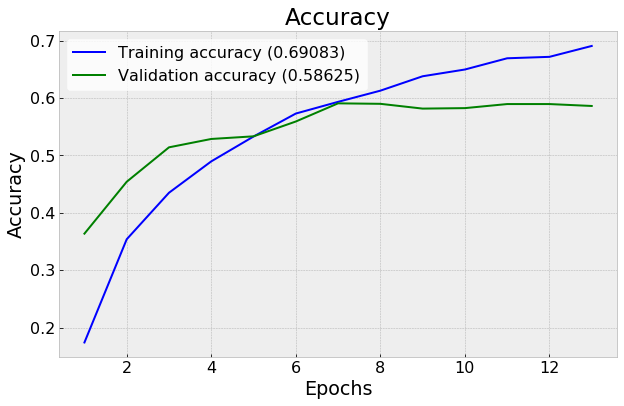

In [31]:
plot_history(vgg16_history, figsize=(10,6))

In [14]:
#make predictions and plot

# define function for accuracy, confusion matrix

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [49]:
y_pred = vgg16_base.predict_generator(validation_generator, max_queue_size =10)

In [74]:
y_pred = np.argmax(y_pred, axis=1).astype(int)
y_pred

array([102,  76,  20, ...,  33,   3,  23])

In [76]:
print(accuracy_score(valid_labels, y_pred))

0.0075


In [71]:
print(classification_report(y_true=valid_labels, y_pred=top_y_preds))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        20
          1       0.00      0.00      0.00        20
          2       0.00      0.00      0.00        20
          3       0.04      0.05      0.04        20
          4       0.00      0.00      0.00        20
          5       0.00      0.00      0.00        20
          6       0.00      0.00      0.00        20
          7       0.00      0.00      0.00        20
          8       0.06      0.05      0.05        20
          9       0.00      0.00      0.00        20
         10       0.00      0.00      0.00        20
         11       0.00      0.00      0.00        20
         12       0.00      0.00      0.00        20
         13       0.00      0.00      0.00        20
         14       0.00      0.00      0.00        20
         15       0.08      0.05      0.06        20
         16       0.00      0.00      0.00        20
         17       0.00      0.00      0.00   

In [49]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5', 
                               verbose=1, save_best_only=True)

vgg16_history = vgg16_base.fit_generator(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=200, 
                    epochs=25, 
                    callbacks=[early_stopping, checkpointer])

Epoch 1/25
200/200 [==============================] - 155s 773ms/step - loss: 4.8965 - acc: 0.0346 - val_loss: 4.0534 - val_acc: 0.1138

Epoch 00001: val_loss improved from inf to 4.05339, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5
Epoch 2/25
200/200 [==============================] - 153s 764ms/step - loss: 4.0129 - acc: 0.1042 - val_loss: 3.3588 - val_acc: 0.2288

Epoch 00002: val_loss improved from 4.05339 to 3.35883, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5
Epoch 3/25
200/200 [==============================] - 152s 762ms/step - loss: 3.4960 - acc: 0.1696 - val_loss: 2.9203 - val_acc: 0.2975

Epoch 00003: val_loss improved from 3.35883 to 2.92027, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5
Epoch 4/25
200/200 [==============================] - 153s 766ms/step - loss: 3.1312 - acc: 0.2313 - val_loss: 2.6103 - val_acc: 0.3529

Epoch 00004: val_loss improved from 2.92027 to 2.61031, saving mod

In [50]:
vgg16_base.save('vgg16_base_2.h5')

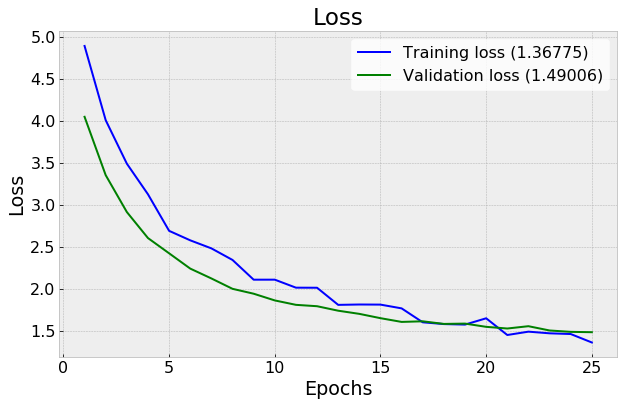

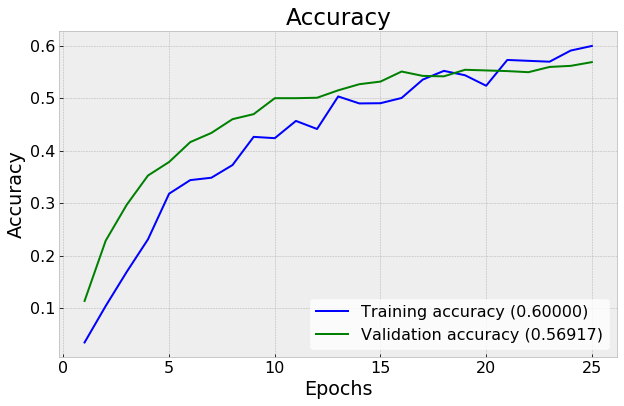

In [51]:
plot_history(vgg16_history, figsize=(10,6))

In [52]:
# let's continue training

checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5', 
                               verbose=1, save_best_only=True)

vgg16_history = vgg16_base.fit_generator(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=200, 
                    epochs=10, 
                    callbacks=[ checkpointer])

Epoch 1/10
200/200 [==============================] - 154s 769ms/step - loss: 1.3842 - acc: 0.5992 - val_loss: 1.5133 - val_acc: 0.5642

Epoch 00001: val_loss improved from inf to 1.51327, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5
Epoch 2/10
200/200 [==============================] - 154s 768ms/step - loss: 1.3567 - acc: 0.6033 - val_loss: 1.4889 - val_acc: 0.5687

Epoch 00002: val_loss improved from 1.51327 to 1.48888, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5
Epoch 3/10
200/200 [==============================] - 153s 763ms/step - loss: 1.3752 - acc: 0.6037 - val_loss: 1.4945 - val_acc: 0.5679

Epoch 00003: val_loss did not improve
Epoch 4/10
200/200 [==============================] - 154s 768ms/step - loss: 1.4007 - acc: 0.5958 - val_loss: 1.4759 - val_acc: 0.5767

Epoch 00004: val_loss improved from 1.48888 to 1.47590, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16.hdf5
Epoch 5/10
200/200 [========

In [53]:
vgg16_base.save('vgg16_base_2.h5')

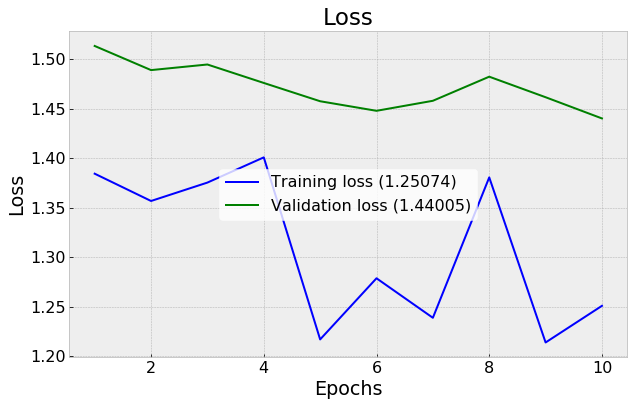

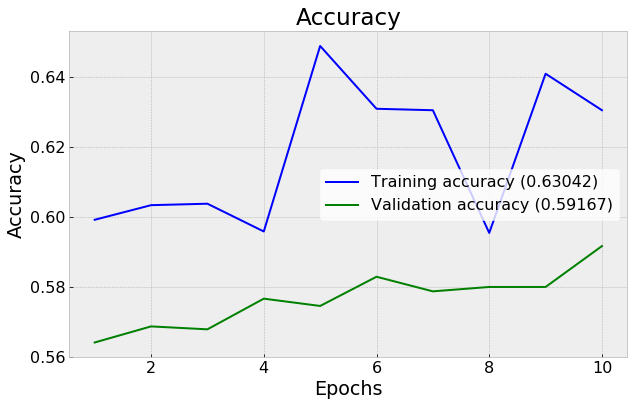

In [54]:
plot_history(vgg16_history, figsize=(10,6))

In [91]:
batch_size = 12

datagen_2 = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, 
                             zoom_range=0.1, horizontal_flip=True, validation_split = 0.2)

generator = datagen_2.flow_from_directory(
        'train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False,
        subset='training') 

Found 9600 images belonging to 120 classes.


In [93]:
# let's try using bottleneck features from the Vgg16 model 

nb_train_samples = 9600
nb_validation_samples = 2400


# instantiate new instante of VGG16 and get bottleneck features of training data

model = VGG16(include_top=False, weights='imagenet')

bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size, max_queue_size=5)
    
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)


ResourceExhaustedError: OOM when allocating tensor with shape[12,3,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block1_conv1_16/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_17_0_0/_3825, block1_conv1_16/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: block5_pool_16/MaxPool/_3827 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_127_block5_pool_16/MaxPool", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'block1_conv1_16/convolution', defined at:
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-93-2fb01ddd338a>", line 9, in <module>
    model = VGG16(include_top=False, weights='imagenet')
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\keras\applications\vgg16.py", line 116, in VGG16
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\keras\layers\convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 3335, in conv2d
    data_format=tf_data_format)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 754, in convolution
    return op(input, filter)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 838, in __call__
    return self.conv_op(inp, filter)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 502, in __call__
    return self.call(inp, filter)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 190, in __call__
    name=self.name)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 725, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[12,3,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block1_conv1_16/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_17_0_0/_3825, block1_conv1_16/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: block5_pool_16/MaxPool/_3827 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_127_block5_pool_16/MaxPool", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [57]:
# obtain bottleneck features of training data

bottleneck_features_validation = model.predict_generator(validation_generator, 2400)
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [80]:
len(bottleneck_features_train)

2400

In [70]:
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=bottleneck_features_train.shape[1:]))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='softmax'))

model.compile(optimizer=adam_op,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_14  (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 120)               30840     
Total params: 162,168
Trainable params: 162,168
Non-trainable params: 0
_________________________________________________________________
None


In [77]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.pre_trained_vgg16_bottleneck.hdf5', 
                               verbose=1, save_best_only=True) 

history = model.fit(bottleneck_features_train, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(bottleneck_features_validation, valid_labels))

ValueError: Input arrays should have the same number of samples as target arrays. Found 2400 input samples and 9600 target samples.

In [43]:
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'train'
validation_data_dir = 'validation'
nb_train_samples = 1200
nb_validation_samples = 800
epochs = 50
batch_size = 16




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_15 (Dense)             (None, 120)               61560     
Total params: 14,776,248
Trainable params: 61,560
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [44]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.pre_trained_vgg16_v2.hdf5', 
                               verbose=1, save_best_only=True)

batch_size=48

vgg16_v2_history = vgg16_v2.fit_generator(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=240, 
                    epochs=20, 
                    callbacks=[checkpointer, early_stopping])

Epoch 1/20
 98/240 [===========>..................] - ETA: 55s - loss: 14.0527 - acc: 0.0094

KeyboardInterrupt: 

In [38]:
# another round of training

vgg16_v2.fit_generator(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=800, 
                    epochs=10, 
                    callbacks=[checkpointer, early_stopping])

Epoch 1/10
800/800 [==============================] - 385s 482ms/step - loss: 5.0574 - acc: 0.5710 - val_loss: 6.5399 - val_acc: 0.4671

Epoch 00001: val_loss improved from 6.56802 to 6.53987, saving model to saved_models/weights.bestaugmented.pre_trained.hdf5
Epoch 2/10
800/800 [==============================] - 384s 480ms/step - loss: 5.0060 - acc: 0.5788 - val_loss: 6.7529 - val_acc: 0.4517

Epoch 00002: val_loss did not improve
Epoch 3/10
800/800 [==============================] - 385s 482ms/step - loss: 4.8536 - acc: 0.5948 - val_loss: 6.8956 - val_acc: 0.4446

Epoch 00003: val_loss did not improve


In [39]:
# another round of training, increase batch size

batch_size=20
vgg16_v2.fit_generator(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=480, 
                    epochs=10, 
                    callbacks=[checkpointer, early_stopping])

Epoch 1/10
480/480 [==============================] - 262s 545ms/step - loss: 4.8157 - acc: 0.6049 - val_loss: 6.5087 - val_acc: 0.4596

Epoch 00001: val_loss improved from 6.53987 to 6.50873, saving model to saved_models/weights.bestaugmented.pre_trained.hdf5
Epoch 2/10
480/480 [==============================] - 263s 548ms/step - loss: 4.7754 - acc: 0.5866 - val_loss: 6.5720 - val_acc: 0.4642

Epoch 00002: val_loss did not improve
Epoch 3/10
480/480 [==============================] - 263s 547ms/step - loss: 4.8430 - acc: 0.5951 - val_loss: 6.4419 - val_acc: 0.4683

Epoch 00003: val_loss improved from 6.50873 to 6.44187, saving model to saved_models/weights.bestaugmented.pre_trained.hdf5
Epoch 4/10
480/480 [==============================] - 261s 544ms/step - loss: 4.4866 - acc: 0.6300 - val_loss: 6.6533 - val_acc: 0.4608

Epoch 00004: val_loss did not improve
Epoch 5/10
480/480 [==============================] - 263s 548ms/step - loss: 4.9115 - acc: 0.5936 - val_loss: 6.8625 - val_acc:

In [40]:
# another round of training, maintain batch size

batch_size=20
vgg16_v2.fit_generator(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=480, 
                    epochs=10, 
                    callbacks=[checkpointer, early_stopping])

Epoch 1/10
480/480 [==============================] - 264s 549ms/step - loss: 4.6897 - acc: 0.6092 - val_loss: 6.8537 - val_acc: 0.4517

Epoch 00001: val_loss did not improve
Epoch 2/10
480/480 [==============================] - 262s 547ms/step - loss: 4.6515 - acc: 0.6104 - val_loss: 6.5844 - val_acc: 0.4763

Epoch 00002: val_loss did not improve
Epoch 3/10
480/480 [==============================] - 261s 545ms/step - loss: 4.6084 - acc: 0.6220 - val_loss: 6.5401 - val_acc: 0.4712

Epoch 00003: val_loss did not improve
Epoch 4/10
480/480 [==============================] - 262s 545ms/step - loss: 4.4628 - acc: 0.6340 - val_loss: 6.6814 - val_acc: 0.4667

Epoch 00004: val_loss did not improve
Epoch 5/10
480/480 [==============================] - 263s 548ms/step - loss: 4.6663 - acc: 0.6248 - val_loss: 6.5071 - val_acc: 0.4838

Epoch 00005: val_loss did not improve
Epoch 6/10
480/480 [==============================] - 262s 545ms/step - loss: 4.6263 - acc: 0.6293 - val_loss: 6.8582 - val_a

In [41]:
# now seems that model is overfitting to the training data.  No additional fitting is needed.
vgg16_v2.save('saved_models/vgg16_v2.h5')

In [22]:
# new line of code.... fit the image data generator first and then train

datagen.fit(train_tensor)